In [1]:
# Might need to pip install json, json_stream, as they are not default libraries
import json
import json_stream
import numpy as np
import os
import yaml

from MODSIM import perform_one_time_step_poseData, create_and_place_simple_legacy_camera, calculate_start_state
from datatypes.vessel import Vessel
from dynamicSceneGenerator import DynamicSceneGenerator
from errorGenerator import ErrorGenerator
from datatypes.cameraRig import CameraRig
from datatypes.virtualCamera import VirtualCamera
from datatypes.conditionState import ConditionState
from visualize import visualize_projections_json_mov, visualize_camera_pose_in_dsg_mov, visualize_dynamic_scene_mov, visualize_detections_json, visualize_annotations_json


# Initialize MODSIM

In [2]:
vehicle_characteristics_path = 'boats_in_fishtank/vehicle_characteristics.json'
dynamics_path = 'boats_in_fishtank/dynamics.json'
simulation_folder = './boats_in_fishtank/simulation/'

In [3]:
ERROR_CONFIG_PATH = 'detector_stats_config.yaml'
WRITE_TO_JSON = True
VISUALIZE=True
CALCULATE = True
MIN_VESSELS = 1
MAX_TIME_STEPS = 1000
FPS = 10

In [4]:
# Camera types: 'STATIC_LEGACY', 'DYNAMIC'
STATIC_LEGACY = 'STATIC_LEGACY'
DYNAMIC = 'DYNAMIC'
DYNAMIC_CORAL_CAMERA = 'DYNAMIC_CORAL_CAMERA'

CAMERA_TYPE = DYNAMIC_CORAL_CAMERA

In [5]:
NO_WAVES = 0
SMALL_WAVES = 1
MEDIUM_WAVES = 2
LARGE_WAVES = 3
HUGE_WAVES = 4


WAVE_SIZE = SMALL_WAVES # int from 0-4

### Temporal model

In [6]:
numb_states = 4

with open('detector_stats_config.yaml', 'r') as stream:
            config = yaml.safe_load(stream)
if config.get('detectionConditions'):
    start_state = calculate_start_state(config.get('detectionConditions'), numb_states)
else:
    # Default is excellent weather
    start_state = calculate_start_state({'precipitation': 0, 'fog': 0, 'wind': 0, 'darkness': 0}, numb_states)

CM = config.get('confusionMatrix')
CM0 = {'FN': round(CM['FN']/3,3), 'FP': round(CM['FP']/3,3), 'TP': 1-round(CM['FN']/3,3), 'TN': 1 - round(CM['FP']/3,3)}
CM1 = {'FN': round(CM['FN']/1.5,3), 'FP': round(CM['FP']/1.5,3), 'TP': 1-round(CM['FN']/1.5,3), 'TN': 1 - round(CM['FP']/1.5,3)}
CM2 = {'FN': round(min(CM['FN']*1.5, 0.99),3), 'FP': round(min(CM['FP']*1.5, 0.99),3), 'TP': 1-round(min(CM['FN']*1.5, 0.99),3), 'TN': 1 - round(min(CM['FP']*1.5, 0.99),3)}
CM3 = {'FN': round(min(CM['FN']*3, 0.99),3), 'FP': round(min(CM['FP']*3, 0.99),3), 'TP': 1-round(min(CM['FN']*3, 0.99),3), 'TN': 1 - round(min(CM['FP']*3, 0.99),3)}


TM =  np.array([[0.996, 0.0017, 0.0006, 0.0006],[0.0022, 0.996, 0.0017, 0.0012],[0.0012, 0.0017, 0.996, 0.0022],[0.0006, 0.0006, 0.0017, 0.996]])
states = {0: ConditionState('Excellent conditions', 0, CM0), 1: ConditionState('Good conditions', 1, CM1), 2: ConditionState('Poor conditions', 2, CM2), 3: ConditionState('Terrible conditions', 3, CM3)}


### Error generator

In [7]:
## Error generator
errorGenerator = ErrorGenerator(ERROR_CONFIG_PATH, temporal_model=True, states=states, start_state=start_state, transition_matrix=TM)

### DSG

In [8]:
# Get vessels
with open(vehicle_characteristics_path, 'r') as f:
    vessel_dict = json.load(f)

# air_draft: int = 2, beam: int = 2, length: int = 4, label: str = "")
vessels = [Vessel(vesselID, length=vessel['length_m'], beam=vessel['width_m'], label=vessel['type']) for vesselID, vessel in vessel_dict.items()]

In [9]:
# Create dynamic scene with vessels
dsg = DynamicSceneGenerator(vessels)

In [10]:
vessel_dict = {vessel.id: vessel for vessel in dsg.get_vessels()}

### Camera

In [11]:
if CAMERA_TYPE == STATIC_LEGACY:
    ##### Static Camera #####
    # Create simple legacy camera and place it in the dynamic scene
    camera = create_and_place_simple_legacy_camera(dsg.get_larges_radius(), dsg.get_path_centre())
    camera_rig = CameraRig(camera, wave_size=WAVE_SIZE)

In [12]:
if CAMERA_TYPE == DYNAMIC:
    ###### Dynamic Camera ######
    focal_length = 50*10**-3
    image_bounds = (3600, 2400) # Pixels (x,y)
    film_size = (36*10**-3, 24*10**-3)
    px = film_size[0]/image_bounds[0]
    py = film_size[1]/image_bounds[1]
    principal_point = (image_bounds[0]/2,image_bounds[1]/2)
    width_of_sensor = 36*10**-3 # Width of sensor
    roll_vcf = 0
    yaw_vcf = 0
    pitch_vcf = np.pi / 100
    vessel = vessels[3]
    pos_vcf = np.array([vessel.get_length()/2, 0, vessel.get_air_draft()/2])

    camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
    camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    camera_rig = CameraRig(camera, vessel)

In [13]:
if CAMERA_TYPE == DYNAMIC_CORAL_CAMERA:
    # https://www.tme.eu/Document/3e25990c825098a96a442d65b17c6632/CORAL-CAMERA-5MP.pdf
    ###### Dynamic Camera ######
    # Intrinsics
    # NB! Make sure everything is in meters
    focal_length = 2.5*10**-3
    image_bounds = (2592, 1933) # Pixels (x,y)
    #film_size = (1.4*10**-3, 1.4*10**-3)
    px = 1.4*10**-6
    py = 1.4*10**-6
    #px = 2*10**-6
    #py = 2*10**-6
    principal_point = (image_bounds[0]/2,image_bounds[1]/2)
    width_of_sensor = 36*10**-3 # Width of sensor

    # Position
    roll_vcf = 0
    yaw_vcf = 0
    pitch_vcf = np.pi/200
    vessel = vessels[3]
    pos_vcf = np.array([vessel.get_length()/2, 0, vessel.get_air_draft()/2])

    camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
    camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    camera_rig = CameraRig(camera, vessel, wave_size=WAVE_SIZE)

# Stream pose data

In [14]:
# Opening JSON file: containing the poses of the moving obstacles - the important stuff
f = open(dynamics_path)
# Returns JSON object as a dictionary stream
data_dynamic = json_stream.load(f, persistent=True)

In [15]:
# Start streaming
time_stream = data_dynamic["time_s"]
for i, t in enumerate(time_stream):
    if float(t) > MAX_TIME_STEPS:
        break
    # One timestep at the time
    for vesselID in time_stream[t].keys():
        # Get current pose data: all given in world coordinates btw.
        center_pos = time_stream[t][vesselID]["center_position_m"]
        heading = time_stream[t][vesselID]["heading_rad"]
        x = center_pos[0]
        y = center_pos[1]
        z = 0
        time_stamp = float(t)
        vessel_dict[vesselID].get_track().addPosition(x, y, z, heading, time_stamp)
    if CALCULATE:    
        perform_one_time_step_poseData(dsg, errorGenerator, camera_rig, time_stamp, writeToJson=WRITE_TO_JSON, path=simulation_folder)


Loading projections from json
Visualizing projections
Moviepy - Building video ./boats_in_fishtank/simulation/projected_points.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/projected_points.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/projected_points.mp4
Moviepy - Building video ./boats_in_fishtank/simulation/detections.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/detections.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/detections.mp4


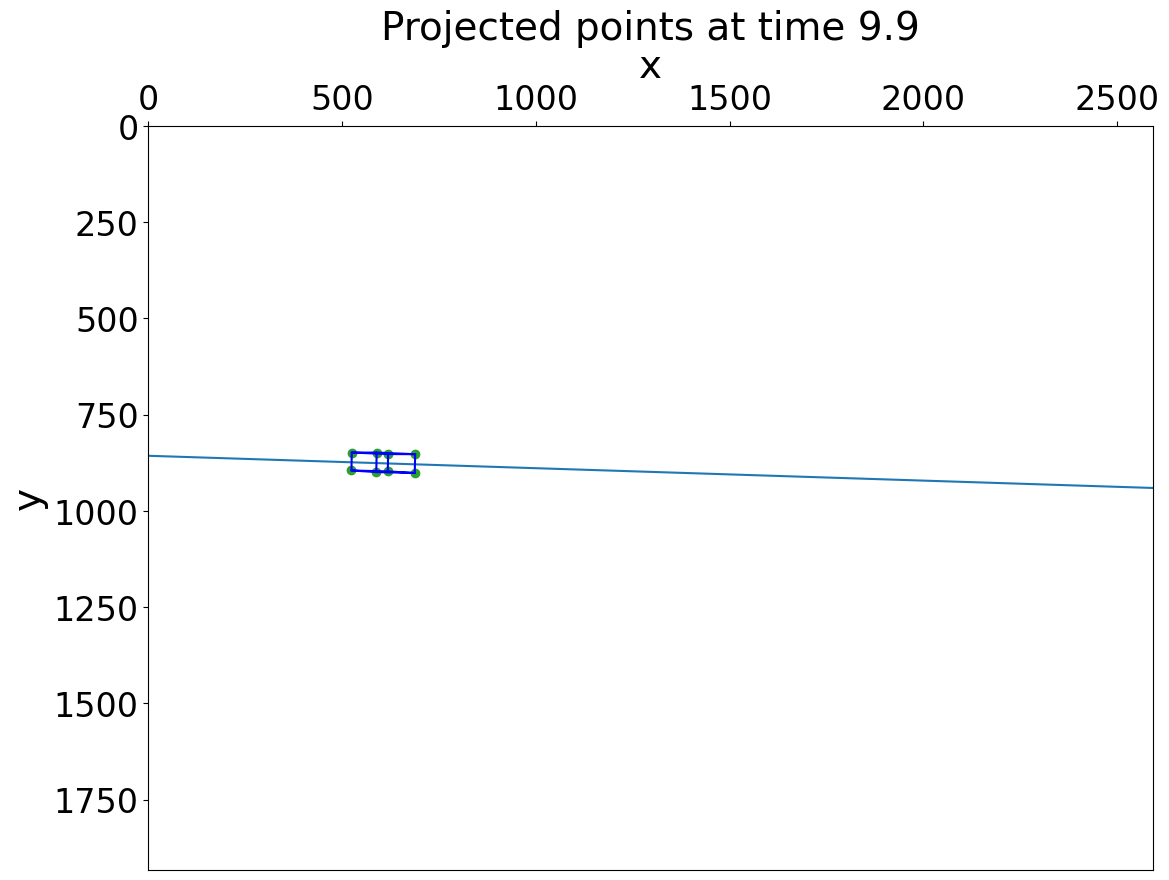

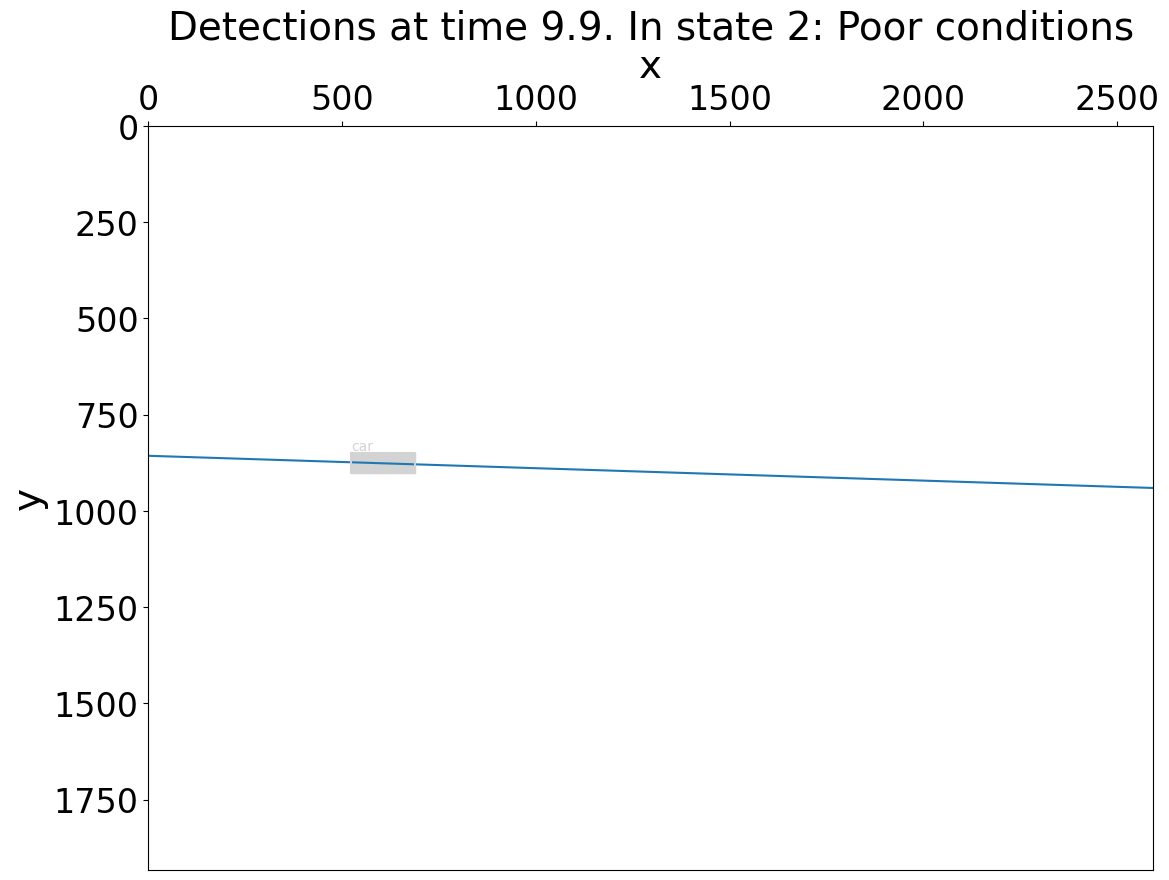

In [16]:
# Visualize from json files
if VISUALIZE:
    pps_path = os.path.join(simulation_folder, 'projectedPoints.json')
    annot_path = os.path.join(simulation_folder, 'annotations.json')
    detection_path = os.path.join(simulation_folder, 'detections.json')
    visualize_dynamic_scene_mov(vessels, folder_path=simulation_folder, fps=FPS, max_time_steps=MAX_TIME_STEPS, y_x_lim=200)
    visualize_camera_pose_in_dsg_mov(camera_rig, vessels, folder_path=simulation_folder, fps=FPS, max_time_steps=MAX_TIME_STEPS, y_x_lim=200)
    visualize_projections_json_mov(pps_path, camera_rig.camera.image_bounds, camera_rig.horizon, folder_path=simulation_folder, fps=FPS, max_time_steps=MAX_TIME_STEPS, display_when_min_vessels=MIN_VESSELS)
    visualize_annotations_json(annot_path, camera_rig.camera.image_bounds, horizon=camera_rig.horizon, folder_path=simulation_folder, fps=FPS, max_time_steps=MAX_TIME_STEPS, display_when_min_vessels=MIN_VESSELS)
    visualize_detections_json(detection_path, camera_rig.camera.image_bounds, horizon=camera_rig.horizon, show_annotations=True, annotations_path=annot_path, folder_path=simulation_folder, fps=FPS, max_time_steps=MAX_TIME_STEPS, display_when_min_vessels=MIN_VESSELS, temporal_state_history=errorGenerator.temporal_model.previous_states, temporal_state_names=errorGenerator.temporal_model.state_names)

